In [1]:
import os
import pymysql
import pandas as pd

In [2]:
host = 'localhost'
port = 3306
user = 'root'
password = os.getenv('MYSQL_PASSWORD')
database = 'money'


In [3]:
conn = pymysql.connect(
    host=host,
    port=port,
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style='whitegrid')

In [5]:
df = pd.read_sql_query(
    """
    select GOLD.day, 
           GOLD.open as go, 
           SILVER.open as so, 
           GOLD.open/SILVER.open as ratio, 
           GOLD.open_interest as g_int, 
           SILVER.open_interest as s_int 
           FROM ( select name, day, open, open_interest from comm_daily where name='GC' ) GOLD 
           JOIN ( select name, day, open, open_interest from comm_daily where name='SI') SILVER 
           ON SILVER.day=GOLD.day
    """
    ,
    conn
)
df.head()

,day,go,so,ratio,g_int,s_int
0,2000-01-03,288.00,5.40,53.333332,158543,76395
1,2000-01-04,288.50,5.39,53.525048,155835,72777
2,2000-01-05,281.25,5.32,52.866540,135005,74093
3,2000-01-06,279.75,5.13,54.532163,158161,73036
4,2000-01-07,280.90,5.10,55.078431,143543,72511


/Users/mikc/.virtualenvs/cv/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


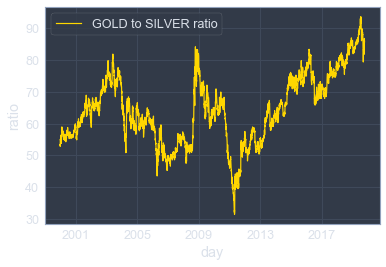

In [6]:
sns.lineplot(df['day'], df['ratio'], label='GOLD to SILVER ratio', color='gold')

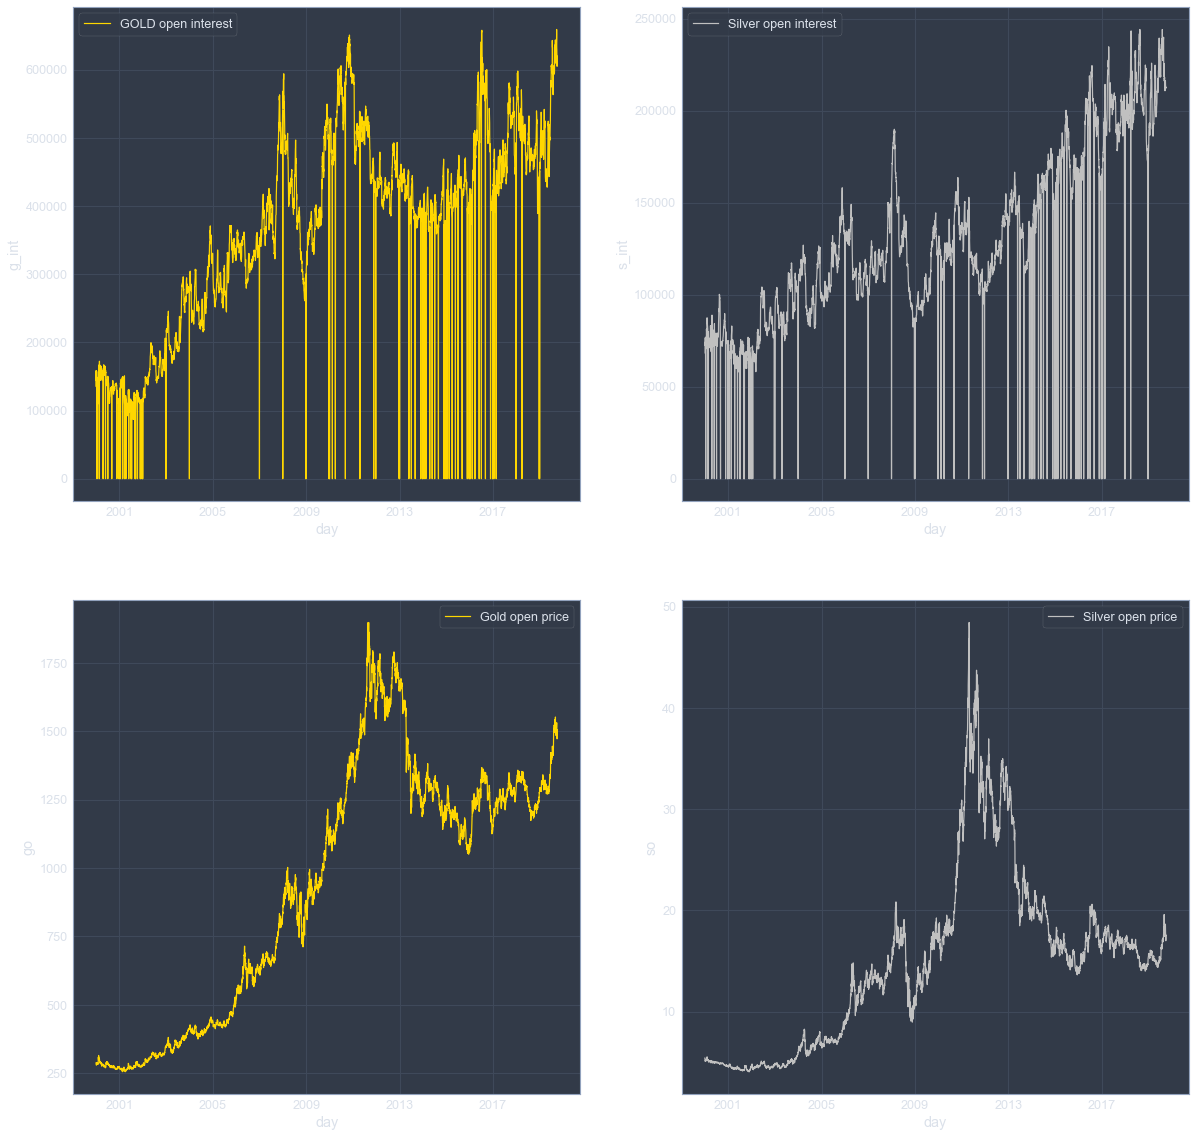

In [7]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.lineplot(df['day'], df['g_int'], label='GOLD open interest', color='gold')
plt.subplot(2,2,2)
sns.lineplot(df['day'], df['s_int'], label='Silver open interest', color='silver')
plt.subplot(2,2,3)
sns.lineplot(df['day'], df['go'], label='Gold open price', color='gold')
plt.subplot(2,2,4)
sns.lineplot(df['day'], df['so'], label='Silver open price', color='silver')

# Real Estates, Dow Jones, Tech-Index and GOLD

In [8]:
def get_ratio(sym):
    sql= """
    select C.day, C.open/T.open as ratio, T.open
    from comm_daily AS C join tickers_daily as T 
    where T.day=C.day and C.name='GC' and T.name='{}'
    """.format(sym)
    #print(sql)
    df = pd.read_sql_query(sql, conn)
    return df

tex=[]
company=["FRESX", "^DJI", "QQQ", "ORCL", "AMZN", "IBM", "SAP", "GOOG", "MSFT", "NVDA", "AAPL", "INTC", "AMD", "TSLA"]
for s in company:
    tex.append(get_ratio(s))
tex[0].head()

,day,ratio,open
0,2000-01-03,19.821060,14.53
1,2000-01-04,20.062587,14.38
2,2000-01-05,19.423343,14.48
3,2000-01-06,18.914807,14.79
4,2000-01-07,18.689288,15.03


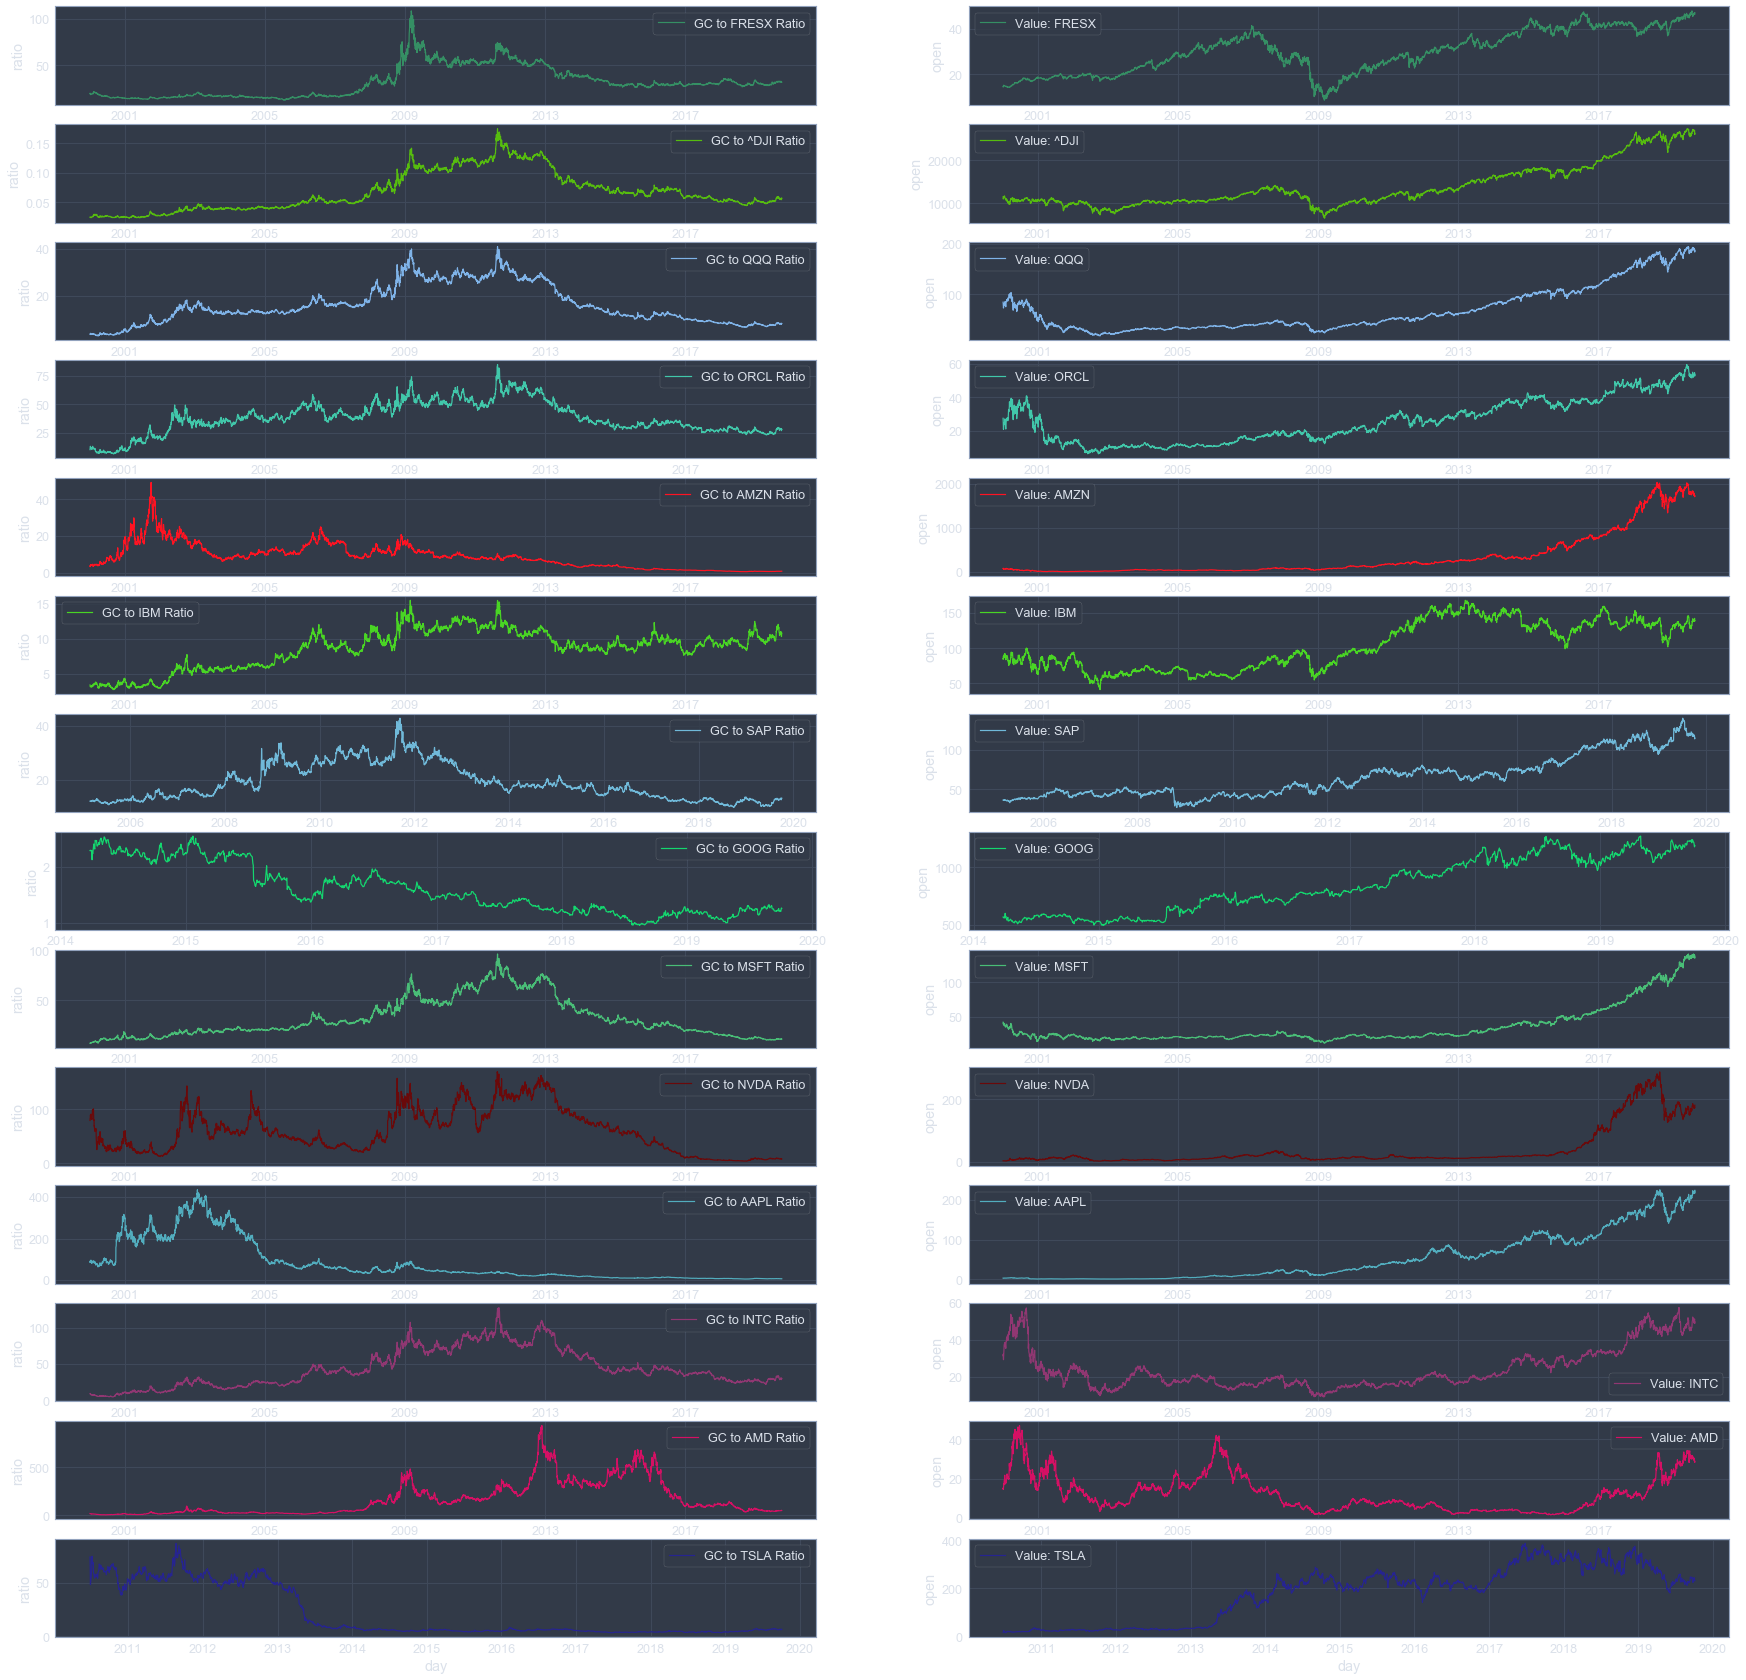

In [9]:
import random
l=len(tex)
plt.figure(figsize=(30,30))
for i in range(len(tex)):
    col="#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    df=tex[i]
    plt.subplot(l, 2, 1+2*i)
    sns.lineplot(df['day'], df['ratio'], label='GC to {} Ratio'.format(company[i]), color=col)
    plt.subplot(l, 2, 2+2*i)
    sns.lineplot(df['day'], df['open'], label='Value: {}'.format(company[i]), color=col)


# Gold Stats

In [12]:
GOLD = pd.read_sql_query("""
   select YEAR(day) as year, 
   avg(value) as average, 
   min(value) as minimum, 
   max(value) as maximum 
   from WGC_daily 
   group by YEAR(day);
""", conn)
#GOLD.tail()

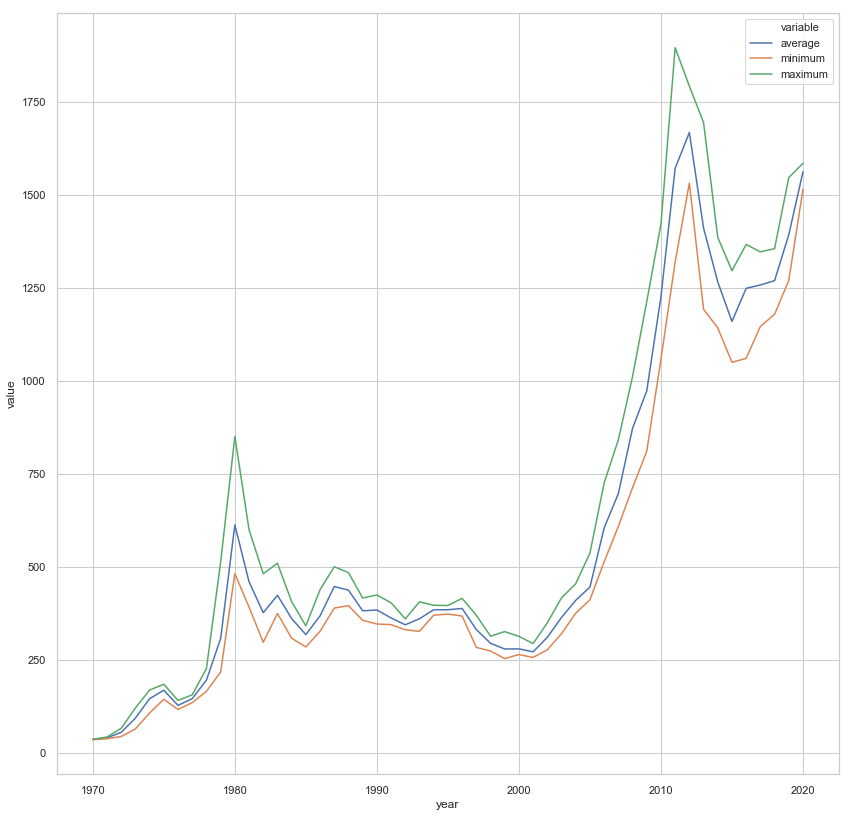

In [13]:
plt.figure(figsize=(14,14))

sns.lineplot(x='year', y='value', hue='variable', 
             data=pd.melt(GOLD, ['year']))

In [14]:
df = pd.read_sql_query("""
select GC.day, GC.value as GOLD, (T.high+T.low)/2 as 'S&P 500' 
from WGC_daily GC JOIN tickers_daily T on GC.day=T.day 
where T.name='^GSPC' ;
""", conn)


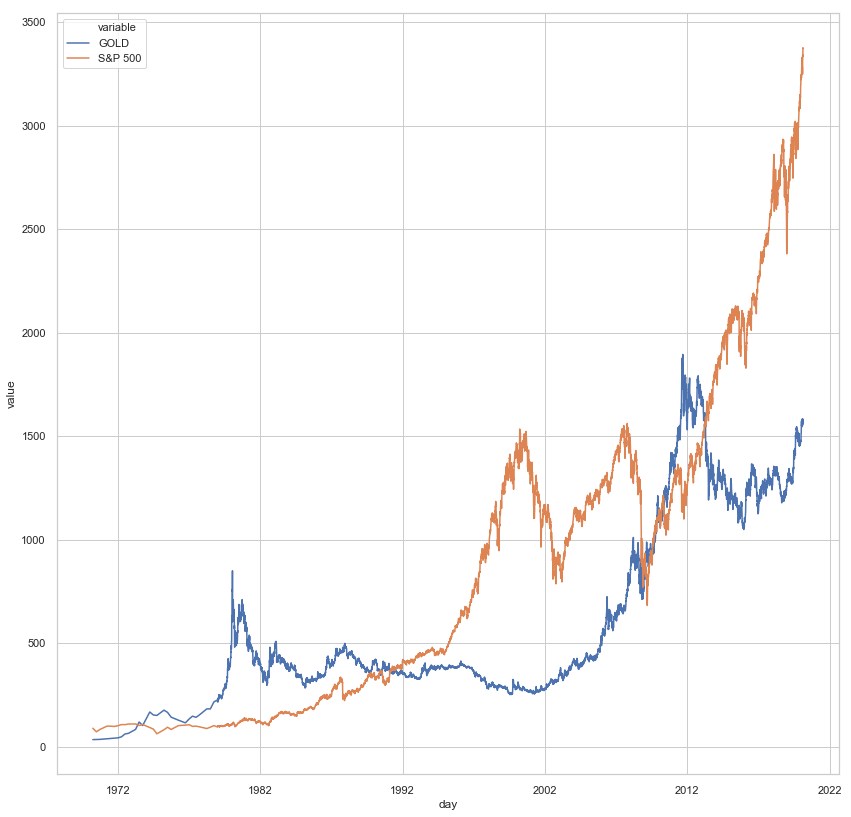

In [15]:
plt.figure(figsize=(14,14))

sns.lineplot(x='day', y='value', hue='variable', 
             data=pd.melt(df, ['day']))

In [16]:
df = pd.read_sql_query("""
select * from us_stats where year>1963
""", conn)
df.head()


,year,unemployment,gdp,inflation
0,1964,5.0,5.8,1.0
1,1965,4.0,6.5,1.9
2,1966,3.8,6.6,3.5
3,1967,3.8,2.7,3.0
4,1968,3.4,4.9,4.7


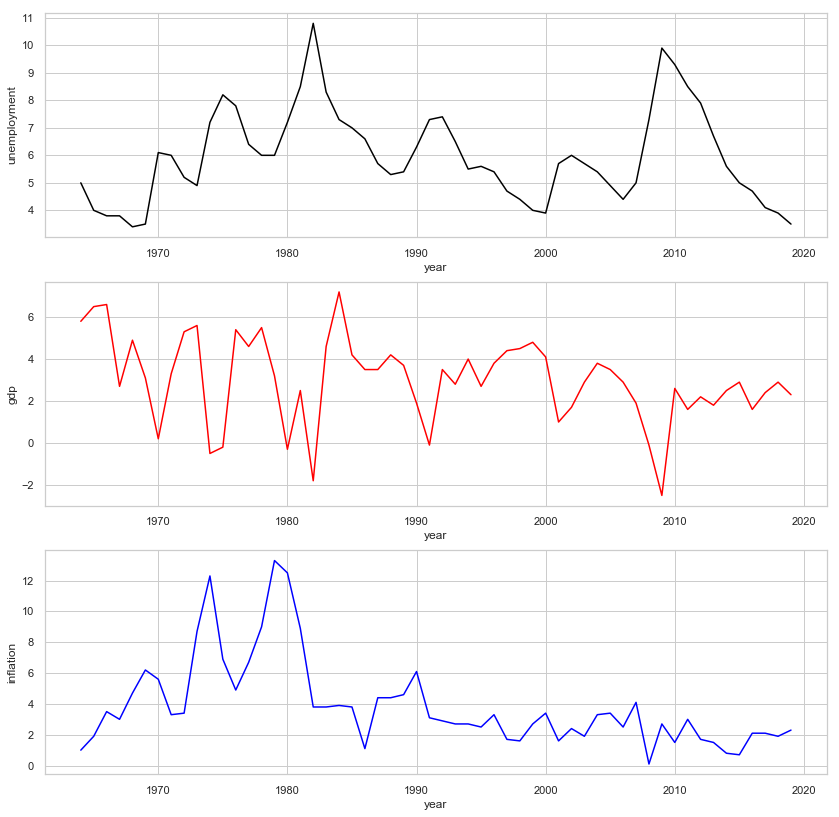

In [17]:
plt.figure(figsize=(14,14))
plt.subplot(3, 1, 1)
sns.lineplot(df['year'], df['unemployment'], color='black')
plt.subplot(3, 1, 2)
sns.lineplot(df['year'], df['gdp'], color='red')
plt.subplot(3, 1, 3)
sns.lineplot(df['year'], df['inflation'], color='blue')